In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
from ds_creation.ds_utility import get_file_count
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from ds_creation.plot_utility import confusion_matrix_plot, metrics_plot_builder, get_metrics



SPLIT_PERC = {'train': 0.8, 'val': 0.2}
TRAIN_DIR = os.path.join('data', 'mammals_calls', 'data')
TEST_DIR = os.path.join('data', 'mammals_calls_test')
AUDIO_DIR = os.path.join('data', 'audio')
MODELS_METRICS_DIR = os.path.join("models_metrics")

h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)


In [43]:
# prendo il csv con gli mfcc e aggiungo una colonna con il nome del file
mfcc_df = pd.read_pickle('audio_data.pkl')
mfcc_df['file_name'] = mfcc_df['audio_files'].apply(lambda x: os.path.basename(x))
mfcc_df = mfcc_df.drop(columns=['idx_gruppo'])
mfcc_df['species'] = mfcc_df['species'].apply(lambda x: x.replace(',', ''))

# specie presenti nei dataset di train e test
species = get_file_count(TRAIN_DIR)
species = species[species['file_count']<1000]['species'].tolist()

# creo un dataframe con i nomi dei file di ogni specie con cui fare training
train_files_dict = {species:os.listdir(os.path.join(TRAIN_DIR, species)) for species in species}
train_files_df = pd.DataFrame([(species, file) for species, files in train_files_dict.items() for file in files], columns=['species', 'file_name'])

# creo un dataframe con i nomi dei file di ogni specie con cui fare testing
test_files_dict = {species:os.listdir(os.path.join(TEST_DIR, species)) for species in species}
test_files_df = pd.DataFrame([(species, file) for species, files in test_files_dict.items() for file in files], columns=['species', 'file_name'])

# creo i dataframe finali di train e test unendo i due dataframe precedenti con il dataframe degli mfcc
train_df = pd.merge(train_files_df, mfcc_df, on=['species', 'file_name'], how='left').dropna().reset_index(drop=True)
test_df = pd.merge(test_files_df, mfcc_df, on=['species', 'file_name'], how='left').dropna().reset_index(drop=True)




In [44]:
y_train = train_df['species']
y_test = test_df['species']
y_mapping = {label:idx for idx, label in enumerate(y_train.unique())}
y_train = y_train.map(y_mapping)
y_test = y_test.map(y_mapping)
print(type(train_df['chunk_list'][0]))
x_train = pd.DataFrame(train_df['chunk_list'].tolist())
x_train.columns = [f'mfcc_feature_{i}' for i in range(x_train.shape[1])]

x_test = pd.DataFrame(test_df['chunk_list'].tolist())
x_test.columns = [f'mfcc_feature_{i}' for i in range(x_test.shape[1])]


<class 'numpy.ndarray'>


In [46]:
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('rf_classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
]

mfcc_pipeline = Pipeline(pipeline_steps)

print("\nInizio addestramento...")
mfcc_pipeline.fit(x_train, y_train)
print("Addestramento completato!")

y_pred = mfcc_pipeline.predict(x_test)

print("\n--- Risultati di Classificazione ---")
print(f"Accuratezza generale: {accuracy_score(y_test, y_pred):.4f}")
print("\nReport Dettagliato:")
print(classification_report(y_test, y_pred))


Inizio addestramento...
Addestramento completato!

--- Risultati di Classificazione ---
Accuratezza generale: 0.9500

Report Dettagliato:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       235
           1       0.99      1.00      1.00       172
           2       0.98      0.99      0.98       137
           3       0.96      0.99      0.98       122
           4       0.94      0.96      0.95        93
           5       1.00      0.99      0.99        80
           6       0.97      0.96      0.97        77
           7       0.98      1.00      0.99        65
           8       0.68      0.67      0.68        61
           9       1.00      0.95      0.97        61
          10       1.00      0.86      0.93        37
          11       1.00      1.00      1.00        35
          12       1.00      1.00      1.00        34
          13       1.00      1.00      1.00        33
          14       1.00      1.00      1.00       

/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elisa/miniconda3/envs/.mmd_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

I0000 00:00:1762114478.813868 3138962 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 50 MB memory:  -> device: 0, name: NVIDIA RTX 4000 Ada Generation, pci bus id: 0000:18:00.0, compute capability: 8.9


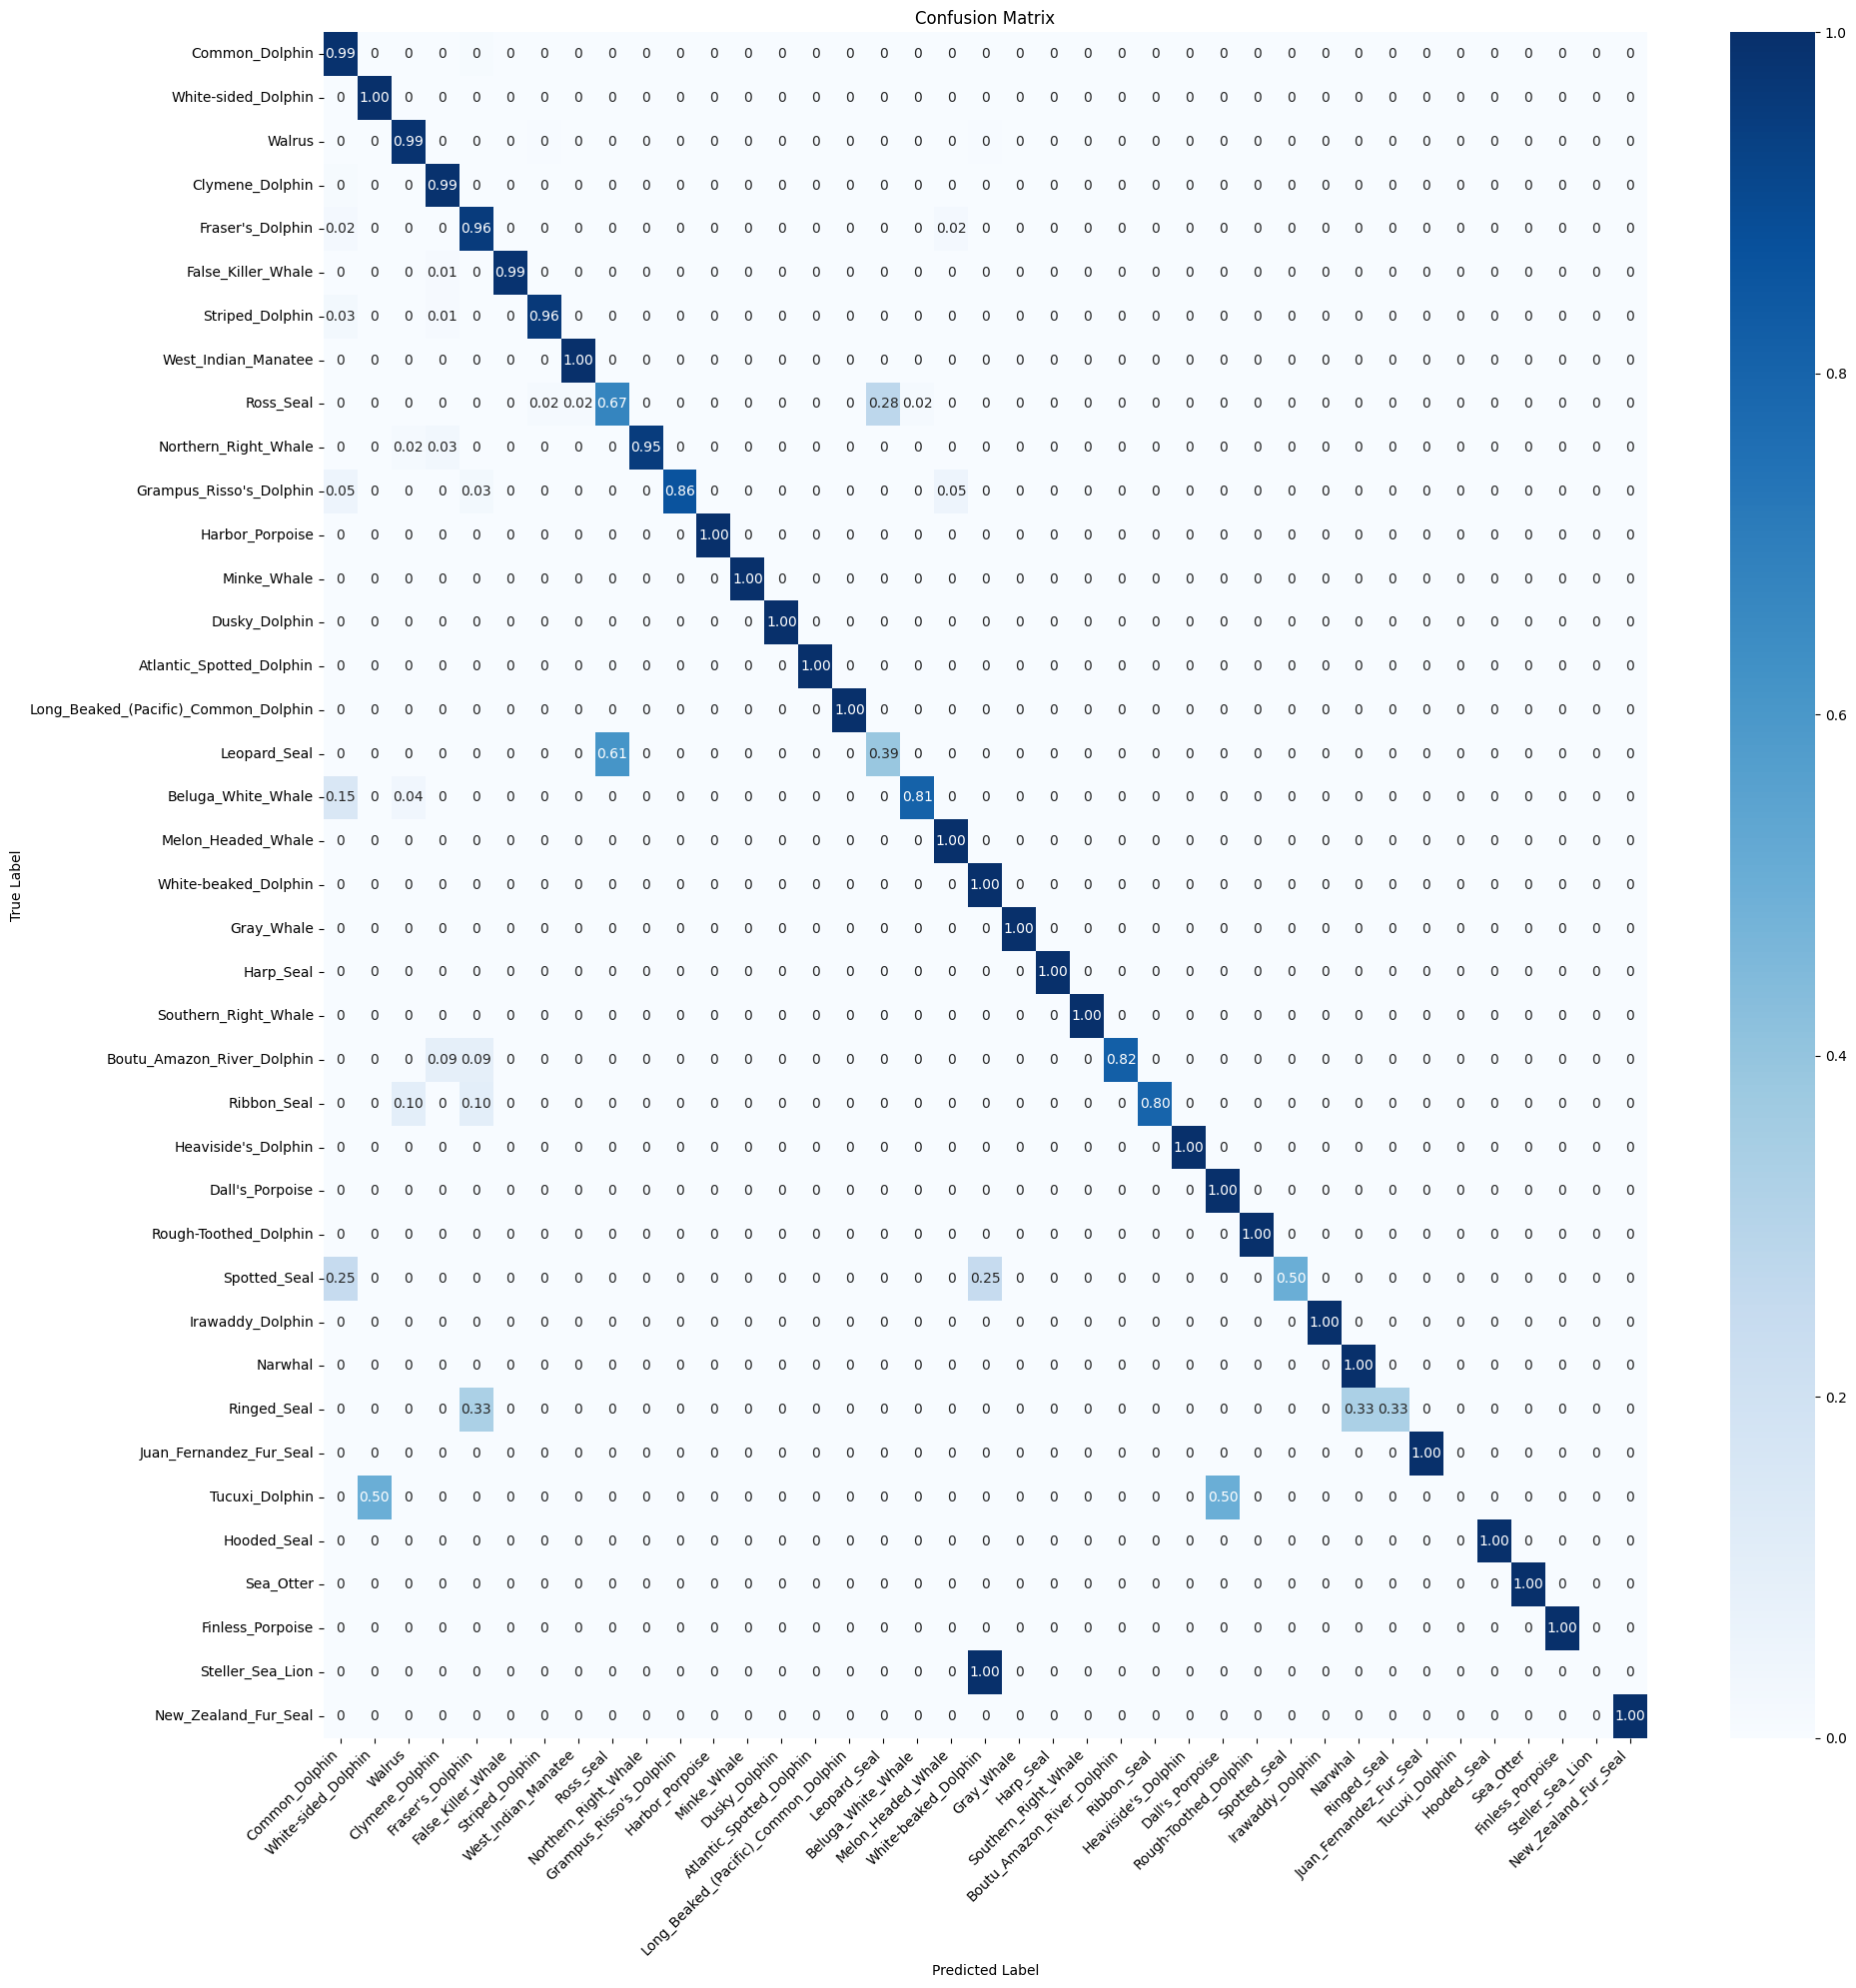

In [50]:
label_list = list(y_mapping.keys())
cm = tf.math.confusion_matrix(y_test, y_pred,).numpy()
accuracy_dict = confusion_matrix_plot(cm, label_list)